---
**License**

 NumCosmoCCLTest

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 NumCosmoCCLTest\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import pyccl as ccl

import sys
import numpy as np
import math
import matplotlib.pyplot as plt


In [2]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
import pylab as plt
def compare(x, y_ccl, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(12, 6)}, xscale = 'linear', yscale = 'log'):
    ccl_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    
    x     = np.array (x)
    y_ccl = np.array (y_ccl)
    y_nc  = np.array (y_nc)
    diff  = np.zeros_like (y_ccl)
    
    non_zind = np.where (y_ccl != 0.0)[0]
    zind     = np.where (y_ccl == 0.0)[0]
    diff[non_zind] = y_nc[non_zind]/y_ccl[non_zind] - 1.0
    diff[zind]     = y_nc[zind] - y_ccl[zind]
    print('[%10s]: rel diff min: %e\trel diff max: %e'%(y_name, min(abs(diff)), max(abs(diff))))
        
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    
    axs[0].plot(x, y_ccl, label='ccl', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    axs[1].plot(x, np.abs (diff), c='r')
    #axs[1].axhline(0, ls=':', c='0', lw=.5)
    axs[1].set_xscale (xscale)
    axs[1].set_yscale (yscale)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, ccl_name))
    
    return fig, axs

In [4]:
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h       = 0.7
A_s     = 2.1e-9
n_s     = 0.96
Neff    = 0.0
mu_0    = 0.1
sigma_0 = 0.1

Omega_v_vals = np.array([0.7, 0.7, 0.7, 0.65, 0.75])
w0_vals      = np.array([-1.0, -0.9, -0.9, -0.9, -0.9])
wa_vals      = np.array([0.0, 0.0, 0.1, 0.1, 0.1])

mnu = [
    [0.04, 0., 0.], [0.05, 0.01, 0.], [0.05, 0., 0.],
    [0.03, 0.02, 0.]]
Neff_mnu = 3.0


In [5]:
def compare_distances(z, Omega_v, w0, wa):
    """
    Compare distances calculated by pyccl with the distances in the benchmark
    file.
    This test is only valid when radiation is explicitly set to 0.
    """
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
        h=h, A_s=A_s, n_s=n_s, Omega_k=Omega_k,
        w0=w0, wa=wa, Omega_g=0)
    
    ccl_cosmo.cosmo.gsl_params.INTEGRATION_EPSREL = 1.0e-13 # Doesn't seem to work
    ccl_cosmo.cosmo.gsl_params.A_SPLINE_NLOG      = 100000  # Doesn't seem to work
    ccl_cosmo.cosmo.gsl_params.A_SPLINE_NA        = 100000  # Doesn't seem to work
        
    cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
    cosmo.omega_x2omega_k ()
    cosmo.param_set_by_name ("H0",        h*100)
    cosmo.param_set_by_name ("Omegak",    Omega_k)
    cosmo.param_set_by_name ("w0",        w0)
    cosmo.param_set_by_name ("w1",        wa)
    cosmo.param_set_by_name ("Omegab",    Omega_b)
    cosmo.param_set_by_name ("Omegac",    Omega_c)
    cosmo.param_set_by_name ("ENnu",      Neff)
    cosmo.param_set_by_name ("Tgamma0",   0.0)
    
    hiprim = Nc.HIPrimPowerLaw.new ()
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
    hiprim.param_set_by_name ("n_SA",       n_s)
    
    cosmo.add_submodel (hiprim)
    
    dist = Nc.Distance.new (5.0)
    dist.prepare (cosmo)
    
    print (dist.comoving_distance_spline.props.reltol)
    print (dist.comoving_distance_spline.props.abstol)
    print (dist.comoving_distance_spline.peek_spline().get_len())
    
    a = 1. / (1. + z)    

    ccl_Og = ccl.omega_x (ccl_cosmo, a, 'matter')
    nc_Og  = [cosmo.E2Omega_m (z_i) / cosmo.E2 (z_i) for z_i in z]
    
    compare (z, ccl_Og, nc_Og, x_name = 'z', y_name = '\Omega_m{}')
    
    ccl_E = ccl.h_over_h0 (ccl_cosmo, a)
    nc_E  = [cosmo.E (z_i) for z_i in z]
    
    compare (z, ccl_E, nc_E, x_name = 'z', y_name = 'E')
    
    ccl_chi = ccl.comoving_radial_distance(ccl_cosmo, a)
    RH_Mpc  = cosmo.RH_Mpc ()
    nc_chi  = [dist.comoving (cosmo, z_i) * RH_Mpc for z_i in z]
    
    compare (z, ccl_chi, nc_chi, x_name = 'z', y_name = 'D')


2.220446049250313e-16
2.2204460492503132e-26
17320
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 6.661338e-16
[         E]: rel diff min: 0.000000e+00	rel diff max: 4.270655e-06
[         D]: rel diff min: 0.000000e+00	rel diff max: 9.380030e-06
2.220446049250313e-16
2.2204460492503132e-26
17599
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 6.661338e-16
[         E]: rel diff min: 0.000000e+00	rel diff max: 4.253896e-06
[         D]: rel diff min: 0.000000e+00	rel diff max: 8.635977e-06
2.220446049250313e-16
2.2204460492503132e-26
18230
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 5.551115e-16
[         E]: rel diff min: 0.000000e+00	rel diff max: 4.239765e-06
[         D]: rel diff min: 0.000000e+00	rel diff max: 8.306690e-06
2.220446049250313e-16
2.2204460492503132e-26
18045
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 6.661338e-16
[         E]: rel diff min: 2.220446e-16	rel diff max: 4.194554e-06
[         D]: rel diff min: 0.000000e+00	rel dif

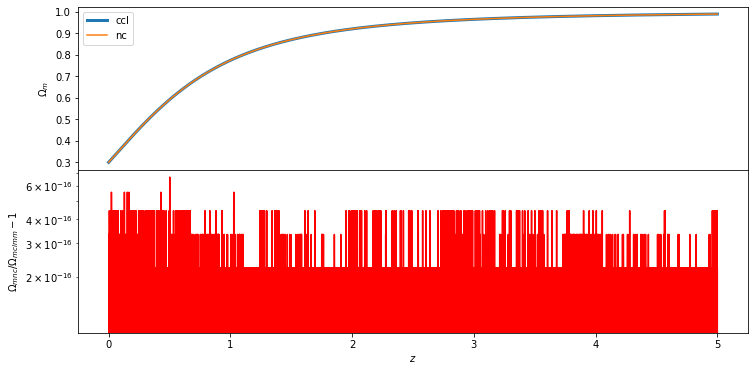

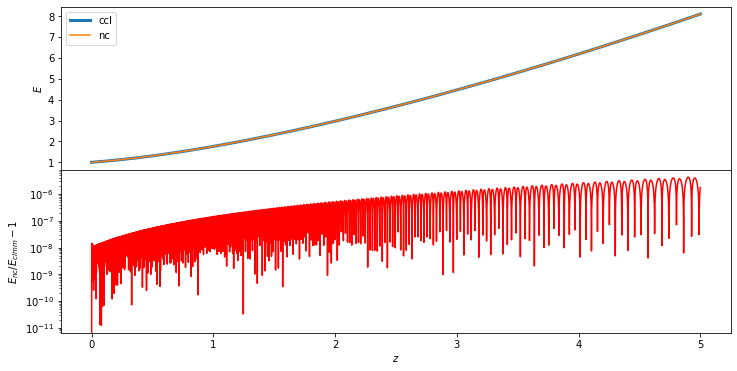

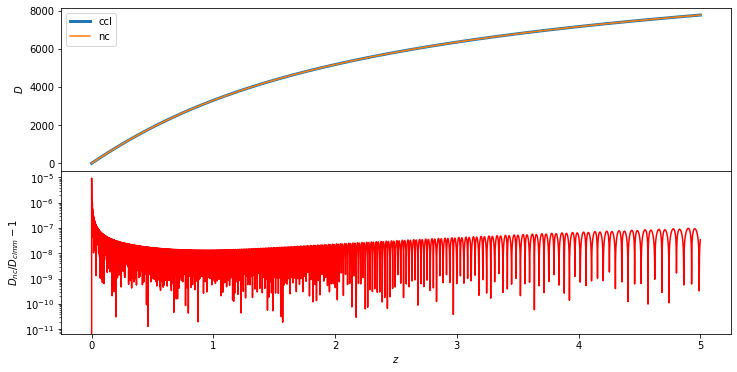

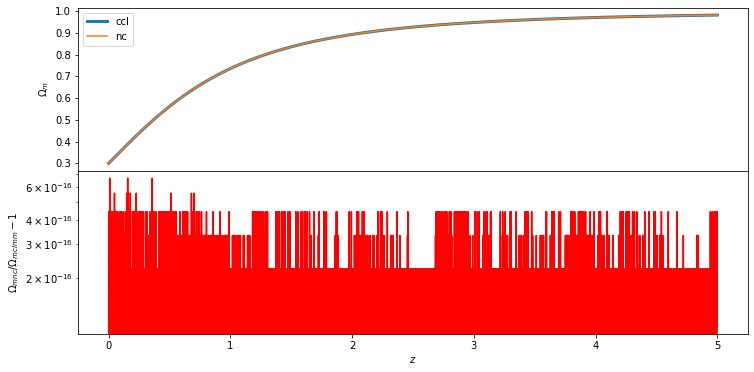

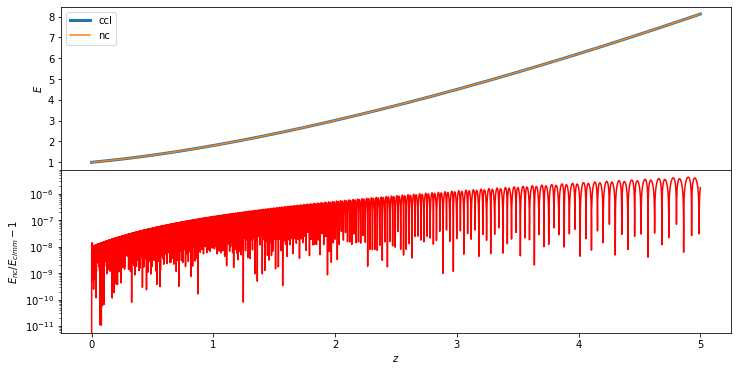

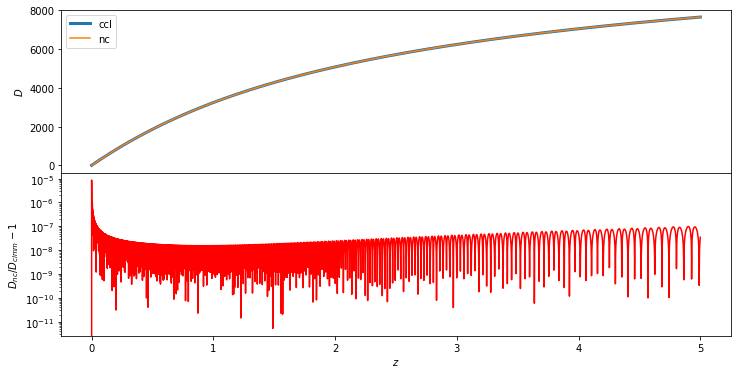

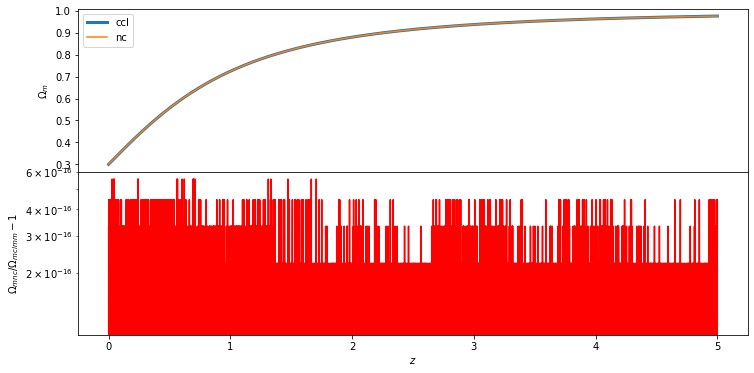

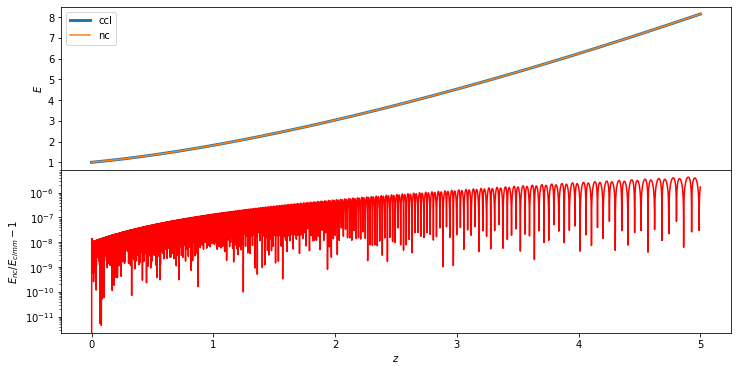

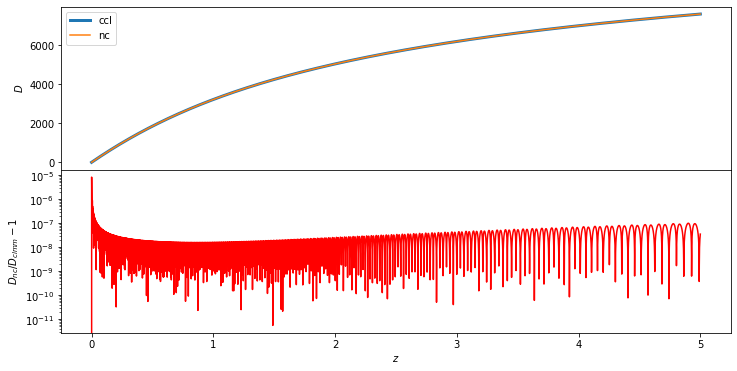

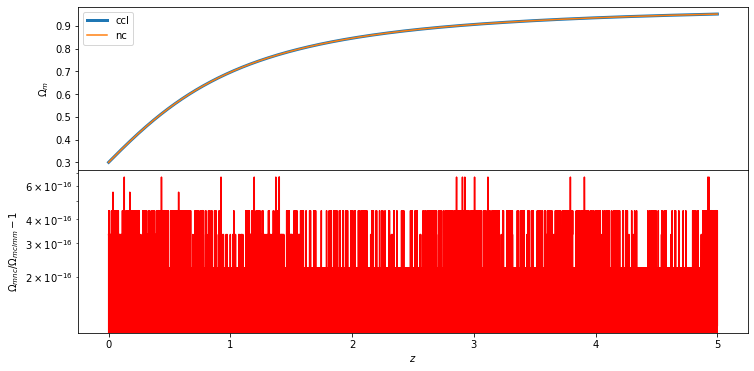

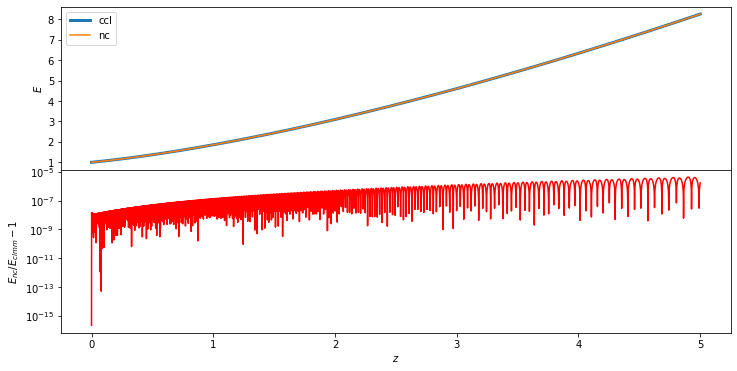

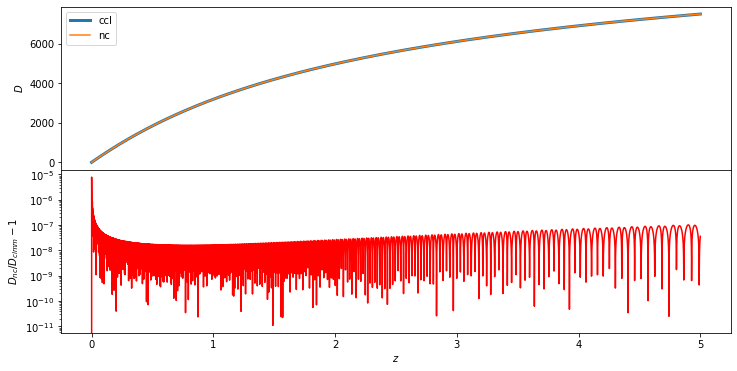

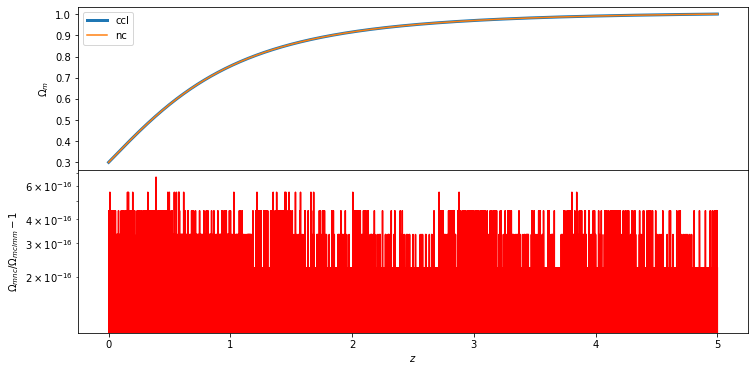

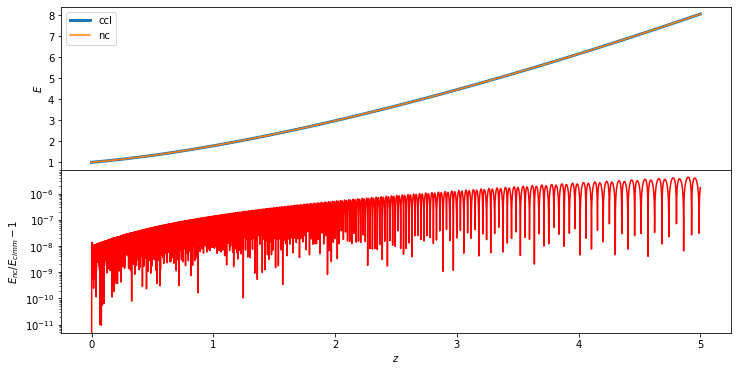

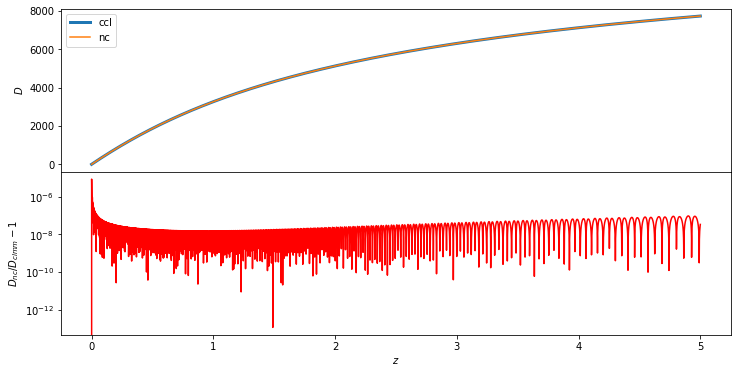

In [6]:
z = np.linspace (0.0, 5.0, 10000)

for i in range(5):
    compare_distances(z, Omega_v_vals[i], w0_vals[i], wa_vals[i])


In [7]:
def compare_ps (k, z, Omega_v, w0, wa):
    """
    Compare ...
    """

    cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
    cosmo.omega_x2omega_k ()
    cosmo.param_set_by_name ("H0",        h * 100)
    cosmo.param_set_by_name ("Omegak",    0.0)
    cosmo.param_set_by_name ("w0",        w0)
    cosmo.param_set_by_name ("w1",        wa)
    cosmo.param_set_by_name ("Omegab",    Omega_b)
    cosmo.param_set_by_name ("Omegac",    Omega_c)
    cosmo.param_set_by_name ("ENnu",      Neff)
    
    # Set Omega_K in a consistent way
    Omega_k = cosmo.Omega_k0 ()
    Omega_v = cosmo.E2Omega_de (0.0)
    T_CMB   = cosmo.T_gamma0 ()

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
        h=h, n_s=n_s, Omega_k=Omega_k,
        w0=w0, wa=wa, Omega_g=0, sigma8 = 0.8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear')

    hiprim = Nc.HIPrimPowerLaw.new ()
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
    hiprim.param_set_by_name ("n_SA",       n_s)
    
    cosmo.add_submodel (hiprim)
    
    dist = Nc.Distance.new (5.0)
    dist.prepare (cosmo)
    
    tf_eh = Nc.TransferFuncEH.new ()
    tf_eh.props.CCL_comp = True
    ps_eh = Nc.PowspecMLTransfer.new (tf_eh)
    ps_eh.prepare (cosmo)
    
    fact = (0.8 / ps_eh.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))**2
    
    #fact = ccl.linear_matter_power (ccl_cosmo, 1.0e-1, 1.0) / ps_eh.eval (cosmo, 0.0, 1.0e-1)
    
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s * fact))
    
    (k_min, k_max) = (min (k), max (k))
    (z_min, z_max) = (min (z), max (z))

    ps_eh.set_kmin (k_min)
    ps_eh.set_kmax (k_max)
    ps_eh.require_zi (z_min)
    ps_eh.require_zf (z_max)

    ps_eh.prepare (cosmo)
    
    for z_i in z:
        a_i = 1.0 / (1.0 + z_i)
        pk_ccl = ccl.linear_matter_power (ccl_cosmo, k, a_i)
        pk_nc  = [ps_eh.eval (cosmo, z_i, k_i) for k_i in k]
        compare (k, pk_ccl, pk_nc, x_name = 'k', y_name = 'P_k(%f)' % z_i, xscale = 'log')    


[P_k(0.000000)]: rel diff min: 5.470260e-04	rel diff max: 5.492323e-04
[P_k(0.500000)]: rel diff min: 5.769134e-04	rel diff max: 5.791198e-04
[P_k(1.000000)]: rel diff min: 6.407914e-04	rel diff max: 6.429980e-04


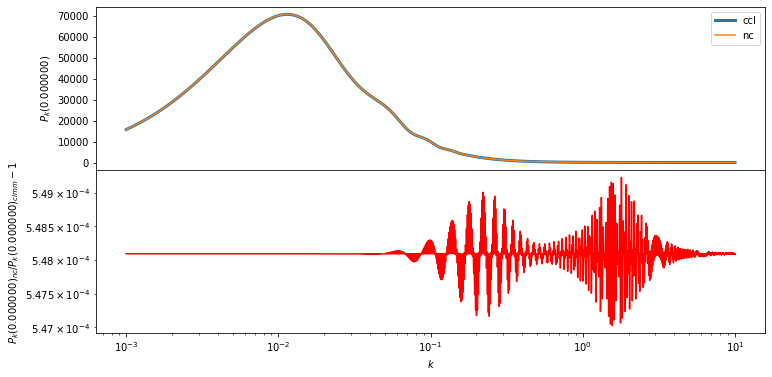

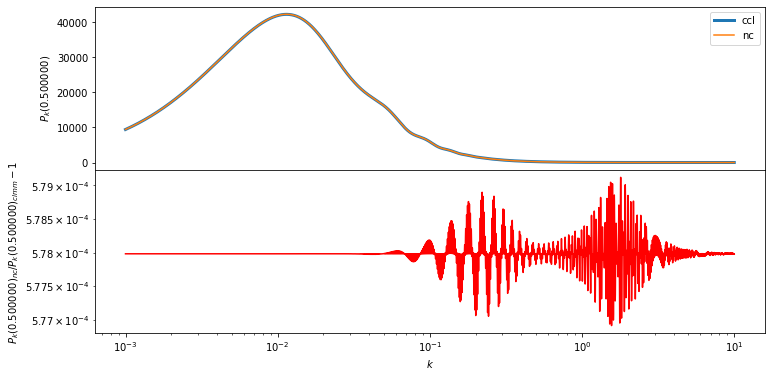

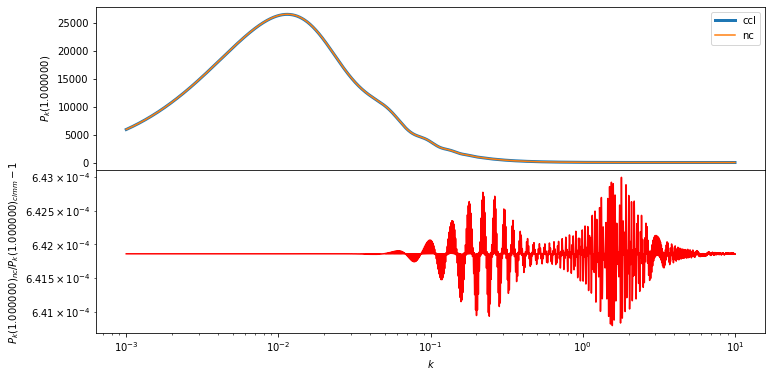

In [8]:
k = np.geomspace (1.0e-3, 1.0e1, 10000)
z = [0.0, 0.5, 1.0]
compare_ps (k, z, 0.7, -1.0, 0.0)


Simplified model of the CCL cross-correlation test using the only tracer that had the test with spin-0 ('NN'), in other words, the NumberCountTracer for g1,g2.

In [14]:
import pyccl as ccl
import numpy as np
from scipy.interpolate import interp1d

#methods = ['fftlog','bessel']
#nztyp = ['analytic','histo']
#trc_typ = ['g1','g2'] <--'NN' is standard correlation type
def ccl_correlation(trc='g1',nztyp='analytic',method='bessel'):
    # Just used to stop the debug when the error is greater than the computation of cross correlation.
    if trc not in ['g1','g2']:
        raise ValueError("Trc_typ invalid", trc)

    if method not in ['fftlog','bessel']:
        raise ValueError("Method invalid!", method)
    
    w0 = -1.0
    wa = 0.0
    
    cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
    cosmo.omega_x2omega_k ()
    cosmo.param_set_by_name ("H0",        h * 100)
    cosmo.param_set_by_name ("Omegak",    0.0)
    cosmo.param_set_by_name ("w0",        w0)
    cosmo.param_set_by_name ("w1",        wa)
    cosmo.param_set_by_name ("Omegab",    Omega_b)
    cosmo.param_set_by_name ("Omegac",    Omega_c)
    cosmo.param_set_by_name ("ENnu",      Neff)
        
    # Set Omega_K in a consistent way
    Omega_k = cosmo.Omega_k0 ()
    Omega_v = cosmo.E2Omega_de (0.0)
    T_CMB   = cosmo.T_gamma0 ()
    
    hiprim = Nc.HIPrimPowerLaw.new ()
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
    hiprim.param_set_by_name ("n_SA",       n_s)
    
    cosmo.add_submodel (hiprim)
    
    dist = Nc.Distance.new (5.0)
    dist.prepare (cosmo)
    
    tf_eh = Nc.TransferFuncEH.new ()
    tf_eh.props.CCL_comp = True
    ps_eh = Nc.PowspecMLTransfer.new (tf_eh)
    ps_eh.prepare (cosmo)

    fact = (0.8 / ps_eh.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))**2
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s * fact))

    ps_eh.prepare (cosmo)
    
    mset = Ncm.MSet.empty_new ()
    mset.set (cosmo)
    
    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
        h=h, n_s=n_s, Omega_k=Omega_k,
        w0=w0, wa=wa, Omega_g=0, sigma8 = 0.8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear')

    ccl_cosmo.cosmo.gsl_params.INTEGRATION_LIMBER_EPSREL = 2.5E-5
    ccl_cosmo.cosmo.gsl_params.INTEGRATION_EPSREL = 2.5E-5

    # Ell-dependent correction factors
    # Set up array of ells
    lmax = 10000
    nls = (lmax - 400) // 20 + 141
    ells = np.zeros(nls)
    ells[:101] = np.arange(101)
    ells[101:121] = ells[100] + (np.arange(20) + 1) * 5
    ells[121:141] = ells[120] + (np.arange(20) + 1) * 10
    ells[141:] = ells[140] + (np.arange(nls - 141) + 1) * 20

    nc_g1 = None
    nc_g2 = None
    
    # Initialize tracers
    if nztyp == 'analytic':
        # Analytic case
        zmean_1 = 1.0
        sigz_1 = 0.15
        zmean_2 = 1.5
        sigz_2 = 0.15
        z1 = [0.2514648,0.2543945,0.2573242,0.2602539,0.2631836,0.2661133,0.269043,0.2719727,0.2749023,0.277832,0.2807617,0.2836914,0.2866211,0.2895508,0.2924805,0.2954102,0.2983398,0.3012695,0.3041992,0.3071289,0.3100586,0.3129883,0.315918,0.3188477,0.3217773,0.324707,0.3276367,0.3305664,0.3334961,0.3364258,0.3393555,0.3422852,0.3452148,0.3481445,0.3510742,0.3540039,0.3569336,0.3598633,0.362793,0.3657227,0.3686523,0.371582,0.3745117,0.3774414,0.3803711,0.3833008,0.3862305,0.3891602,0.3920898,0.3950195,0.3979492,0.4008789,0.4038086,0.4067383,0.409668,0.4125977,0.4155273,0.418457,0.4213867,0.4243164,0.4272461,0.4301758,0.4331055,0.4360352,0.4389648,0.4418945,0.4448242,0.4477539,0.4506836,0.4536133,0.456543,0.4594727,0.4624023,0.465332,0.4682617,0.4711914,0.4741211,0.4770508,0.4799805,0.4829102,0.4858398,0.4887695,0.4916992,0.4946289,0.4975586,0.5004883,0.503418,0.5063477,0.5092773,0.512207,0.5151367,0.5180664,0.5209961,0.5239258,0.5268555,0.5297852,0.5327148,0.5356445,0.5385742,0.5415039,0.5444336,0.5473633,0.550293,0.5532227,0.5561523,0.559082,0.5620117,0.5649414,0.5678711,0.5708008,0.5737305,0.5766602,0.5795898,0.5825195,0.5854492,0.5883789,0.5913086,0.5942383,0.597168,0.6000977,0.6030273,0.605957,0.6088867,0.6118164,0.6147461,0.6176758,0.6206055,0.6235352,0.6264648,0.6293945,0.6323242,0.6352539,0.6381836,0.6411133,0.644043,0.6469727,0.6499023,0.652832,0.6557617,0.6586914,0.6616211,0.6645508,0.6674805,0.6704102,0.6733398,0.6762695,0.6791992,0.6821289,0.6850586,0.6879883,0.690918,0.6938477,0.6967773,0.699707,0.7026367,0.7055664,0.7084961,0.7114258,0.7143555,0.7172852,0.7202148,0.7231445,0.7260742,0.7290039,0.7319336,0.7348633,0.737793,0.7407227,0.7436523,0.746582,0.7495117,0.7524414,0.7553711,0.7583008,0.7612305,0.7641602,0.7670898,0.7700195,0.7729492,0.7758789,0.7788086,0.7817383,0.784668,0.7875977,0.7905273,0.793457,0.7963867,0.7993164,0.8022461,0.8051758,0.8081055,0.8110352,0.8139648,0.8168945,0.8198242,0.8227539,0.8256836,0.8286133,0.831543,0.8344727,0.8374023,0.840332,0.8432617,0.8461914,0.8491211,0.8520508,0.8549805,0.8579102,0.8608398,0.8637695,0.8666992,0.8696289,0.8725586,0.8754883,0.878418,0.8813477,0.8842773,0.887207,0.8901367,0.8930664,0.8959961,0.8989258,0.9018555,0.9047852,0.9077148,0.9106445,0.9135742,0.9165039,0.9194336,0.9223633,0.925293,0.9282227,0.9311523,0.934082,0.9370117,0.9399414,0.9428711,0.9458008,0.9487305,0.9516602,0.9545898,0.9575195,0.9604492,0.9633789,0.9663086,0.9692383,0.972168,0.9750977,0.9780273,0.980957,0.9838867,0.9868164,0.9897461,0.9926758,0.9956055,0.9985352,1.001465,1.004395,1.007324,1.010254,1.013184,1.016113,1.019043,1.021973,1.024902,1.027832,1.030762,1.033691,1.036621,1.039551,1.04248,1.04541,1.04834,1.05127,1.054199,1.057129,1.060059,1.062988,1.065918,1.068848,1.071777,1.074707,1.077637,1.080566,1.083496,1.086426,1.089355,1.092285,1.095215,1.098145,1.101074,1.104004,1.106934,1.109863,1.112793,1.115723,1.118652,1.121582,1.124512,1.127441,1.130371,1.133301,1.13623,1.13916,1.14209,1.14502,1.147949,1.150879,1.153809,1.156738,1.159668,1.162598,1.165527,1.168457,1.171387,1.174316,1.177246,1.180176,1.183105,1.186035,1.188965,1.191895,1.194824,1.197754,1.200684,1.203613,1.206543,1.209473,1.212402,1.215332,1.218262,1.221191,1.224121,1.227051,1.22998,1.23291,1.23584,1.23877,1.241699,1.244629,1.247559,1.250488,1.253418,1.256348,1.259277,1.262207,1.265137,1.268066,1.270996,1.273926,1.276855,1.279785,1.282715,1.285645,1.288574,1.291504,1.294434,1.297363,1.300293,1.303223,1.306152,1.309082,1.312012,1.314941,1.317871,1.320801,1.32373,1.32666,1.32959,1.33252,1.335449,1.338379,1.341309,1.344238,1.347168,1.350098,1.353027,1.355957,1.358887,1.361816,1.364746,1.367676,1.370605,1.373535,1.376465,1.379395,1.382324,1.385254,1.388184,1.391113,1.394043,1.396973,1.399902,1.402832,1.405762,1.408691,1.411621,1.414551,1.41748,1.42041,1.42334,1.42627,1.429199,1.432129,1.435059,1.437988,1.440918,1.443848,1.446777,1.449707,1.452637,1.455566,1.458496,1.461426,1.464355,1.467285,1.470215,1.473145,1.476074,1.479004,1.481934,1.484863,1.487793,1.490723,1.493652,1.496582,1.499512,1.502441,1.505371,1.508301,1.51123,1.51416,1.51709,1.52002,1.522949,1.525879,1.528809,1.531738,1.534668,1.537598,1.540527,1.543457,1.546387,1.549316,1.552246,1.555176,1.558105,1.561035,1.563965,1.566895,1.569824,1.572754,1.575684,1.578613,1.581543,1.584473,1.587402,1.590332,1.593262,1.596191,1.599121,1.602051,1.60498,1.60791,1.61084,1.61377,1.616699,1.619629,1.622559,1.625488,1.628418,1.631348,1.634277,1.637207,1.640137,1.643066,1.645996,1.648926,1.651855,1.654785,1.657715,1.660645,1.663574,1.666504,1.669434,1.672363,1.675293,1.678223,1.681152,1.684082,1.687012,1.689941,1.692871,1.695801,1.69873,1.70166,1.70459,1.70752,1.710449,1.713379,1.716309,1.719238,1.722168,1.725098,1.728027,1.730957,1.733887,1.736816,1.739746,1.742676,1.745605,1.748535]
        z2 = [0.7514648,0.7543945,0.7573242,0.7602539,0.7631836,0.7661133,0.769043,0.7719727,0.7749023,0.777832,0.7807617,0.7836914,0.7866211,0.7895508,0.7924805,0.7954102,0.7983398,0.8012695,0.8041992,0.8071289,0.8100586,0.8129883,0.815918,0.8188477,0.8217773,0.824707,0.8276367,0.8305664,0.8334961,0.8364258,0.8393555,0.8422852,0.8452148,0.8481445,0.8510742,0.8540039,0.8569336,0.8598633,0.862793,0.8657227,0.8686523,0.871582,0.8745117,0.8774414,0.8803711,0.8833008,0.8862305,0.8891602,0.8920898,0.8950195,0.8979492,0.9008789,0.9038086,0.9067383,0.909668,0.9125977,0.9155273,0.918457,0.9213867,0.9243164,0.9272461,0.9301758,0.9331055,0.9360352,0.9389648,0.9418945,0.9448242,0.9477539,0.9506836,0.9536133,0.956543,0.9594727,0.9624023,0.965332,0.9682617,0.9711914,0.9741211,0.9770508,0.9799805,0.9829102,0.9858398,0.9887695,0.9916992,0.9946289,0.9975586,1.000488,1.003418,1.006348,1.009277,1.012207,1.015137,1.018066,1.020996,1.023926,1.026855,1.029785,1.032715,1.035645,1.038574,1.041504,1.044434,1.047363,1.050293,1.053223,1.056152,1.059082,1.062012,1.064941,1.067871,1.070801,1.07373,1.07666,1.07959,1.08252,1.085449,1.088379,1.091309,1.094238,1.097168,1.100098,1.103027,1.105957,1.108887,1.111816,1.114746,1.117676,1.120605,1.123535,1.126465,1.129395,1.132324,1.135254,1.138184,1.141113,1.144043,1.146973,1.149902,1.152832,1.155762,1.158691,1.161621,1.164551,1.16748,1.17041,1.17334,1.17627,1.179199,1.182129,1.185059,1.187988,1.190918,1.193848,1.196777,1.199707,1.202637,1.205566,1.208496,1.211426,1.214355,1.217285,1.220215,1.223145,1.226074,1.229004,1.231934,1.234863,1.237793,1.240723,1.243652,1.246582,1.249512,1.252441,1.255371,1.258301,1.26123,1.26416,1.26709,1.27002,1.272949,1.275879,1.278809,1.281738,1.284668,1.287598,1.290527,1.293457,1.296387,1.299316,1.302246,1.305176,1.308105,1.311035,1.313965,1.316895,1.319824,1.322754,1.325684,1.328613,1.331543,1.334473,1.337402,1.340332,1.343262,1.346191,1.349121,1.352051,1.35498,1.35791,1.36084,1.36377,1.366699,1.369629,1.372559,1.375488,1.378418,1.381348,1.384277,1.387207,1.390137,1.393066,1.395996,1.398926,1.401855,1.404785,1.407715,1.410645,1.413574,1.416504,1.419434,1.422363,1.425293,1.428223,1.431152,1.434082,1.437012,1.439941,1.442871,1.445801,1.44873,1.45166,1.45459,1.45752,1.460449,1.463379,1.466309,1.469238,1.472168,1.475098,1.478027,1.480957,1.483887,1.486816,1.489746,1.492676,1.495605,1.498535,1.501465,1.504395,1.507324,1.510254,1.513184,1.516113,1.519043,1.521973,1.524902,1.527832,1.530762,1.533691,1.536621,1.539551,1.54248,1.54541,1.54834,1.55127,1.554199,1.557129,1.560059,1.562988,1.565918,1.568848,1.571777,1.574707,1.577637,1.580566,1.583496,1.586426,1.589355,1.592285,1.595215,1.598145,1.601074,1.604004,1.606934,1.609863,1.612793,1.615723,1.618652,1.621582,1.624512,1.627441,1.630371,1.633301,1.63623,1.63916,1.64209,1.64502,1.647949,1.650879,1.653809,1.656738,1.659668,1.662598,1.665527,1.668457,1.671387,1.674316,1.677246,1.680176,1.683105,1.686035,1.688965,1.691895,1.694824,1.697754,1.700684,1.703613,1.706543,1.709473,1.712402,1.715332,1.718262,1.721191,1.724121,1.727051,1.72998,1.73291,1.73584,1.73877,1.741699,1.744629,1.747559,1.750488,1.753418,1.756348,1.759277,1.762207,1.765137,1.768066,1.770996,1.773926,1.776855,1.779785,1.782715,1.785645,1.788574,1.791504,1.794434,1.797363,1.800293,1.803223,1.806152,1.809082,1.812012,1.814941,1.817871,1.820801,1.82373,1.82666,1.82959,1.83252,1.835449,1.838379,1.841309,1.844238,1.847168,1.850098,1.853027,1.855957,1.858887,1.861816,1.864746,1.867676,1.870605,1.873535,1.876465,1.879395,1.882324,1.885254,1.888184,1.891113,1.894043,1.896973,1.899902,1.902832,1.905762,1.908691,1.911621,1.914551,1.91748,1.92041,1.92334,1.92627,1.929199,1.932129,1.935059,1.937988,1.940918,1.943848,1.946777,1.949707,1.952637,1.955566,1.958496,1.961426,1.964355,1.967285,1.970215,1.973145,1.976074,1.979004,1.981934,1.984863,1.987793,1.990723,1.993652,1.996582,1.999512,2.002441,2.005371,2.008301,2.01123,2.01416,2.01709,2.02002,2.022949,2.025879,2.028809,2.031738,2.034668,2.037598,2.040527,2.043457,2.046387,2.049316,2.052246,2.055176,2.058105,2.061035,2.063965,2.066895,2.069824,2.072754,2.075684,2.078613,2.081543,2.084473,2.087402,2.090332,2.093262,2.096191,2.099121,2.102051,2.10498,2.10791,2.11084,2.11377,2.116699,2.119629,2.122559,2.125488,2.128418,2.131348,2.134277,2.137207,2.140137,2.143066,2.145996,2.148926,2.151855,2.154785,2.157715,2.160645,2.163574,2.166504,2.169434,2.172363,2.175293,2.178223,2.181152,2.184082,2.187012,2.189941,2.192871,2.195801,2.19873,2.20166,2.20459,2.20752,2.210449,2.213379,2.216309,2.219238,2.222168,2.225098,2.228027,2.230957,2.233887,2.236816,2.239746,2.242676,2.245605,2.248535]
        z1=np.array(z1)
        z2=np.array(z2)
        pz1 = np.exp(-0.5 * ((z1 - zmean_1) / sigz_1) ** 2)
        pz2 = np.exp(-0.5 * ((z2 - zmean_2) / sigz_2) ** 2)

    elif nztyp == 'histo':
        # Histogram case
        z1 = [0.51125,0.51875,0.52625,0.5337500000000001,0.54125,0.5487500000000001,0.55625,0.5637500000000001,0.57125,0.57875,0.58625,0.59375,0.6012500000000001,0.60875,0.6162500000000001,0.62375,0.63125,0.63875,0.64625,0.65375,0.66125,0.6687500000000001,0.67625,0.6837500000000001,0.69125,0.69875,0.70625,0.71375,0.7212500000000001,0.72875,0.7362500000000001,0.74375,0.7512500000000001,0.75875,0.76625,0.77375,0.78125,0.7887500000000001,0.79625,0.8037500000000001,0.81125,0.81875,0.82625,0.83375,0.84125,0.84875,0.8562500000000001,0.86375,0.8712500000000001,0.87875,0.88625,0.89375,0.90125,0.9087500000000001,0.91625,0.9237500000000001,0.93125,0.9387500000000001,0.94625,0.95375,0.96125,0.96875,0.9762500000000001,0.98375,0.9912500000000001,0.99875,1.0062499999999999,1.01375,1.02125,1.0287499999999998,1.03625,1.04375,1.05125,1.0587499999999999,1.06625,1.07375,1.0812499999999998,1.0887499999999999,1.09625,1.10375,1.1112499999999998,1.11875,1.12625,1.1337499999999998,1.1412499999999999,1.14875,1.15625,1.1637499999999998,1.17125,1.17875,1.18625,1.1937499999999999,1.20125,1.20875,1.2162499999999998,1.22375,1.23125,1.23875,1.2462499999999999,1.25375,1.26125,1.2687499999999998,1.2762499999999999,1.28375,1.29125,1.2987499999999998,1.30625,1.31375,1.3212499999999998,1.3287499999999999,1.33625,1.34375,1.3512499999999998,1.35875,1.36625,1.37375,1.3812499999999999,1.38875,1.39625,1.4037499999999998,1.41125,1.41875,1.42625,1.4337499999999999,1.44125,1.44875,1.4562499999999998,1.4637499999999999,1.47125,1.47875,1.4862499999999998,1.49375,1.50125,1.5087499999999998,1.5162499999999999,1.52375,1.53125,1.5387499999999998,1.54625,1.55375,1.56125,1.5687499999999999,1.57625,1.58375,1.5912499999999998,1.59875,1.60625,1.61375,1.6212499999999999,1.62875,1.63625,1.6437499999999998,1.6512499999999999,1.65875,1.66625,1.6737499999999998,1.68125,1.68875,1.6962499999999998,1.7037499999999999,1.71125,1.71875,1.7262499999999998,1.73375,1.74125,1.74875,1.7562499999999999,1.76375,1.77125,1.7787499999999998,1.78625,1.79375,1.80125,1.8087499999999999,1.81625,1.82375,1.8312499999999998,1.8387499999999999,1.84625,1.85375,1.8612499999999998,1.86875,1.87625,1.8837499999999998,1.8912499999999999,1.89875,1.90625,1.9137499999999998,1.92125,1.92875,1.93625,1.9437499999999999,1.95125,1.95875,1.9662499999999998,1.97375,1.98125,1.98875,1.9962499999999999]
        pz1 = [0.03042845,0.03414402,0.03799253,0.04299767,0.05033486,0.06090954,0.07214195,0.08122409,0.09440498,0.1069006,0.1193231,0.1345755,0.1574345,0.1814089,0.2129027,0.2362395,0.2668045,0.3002025,0.3352957,0.3745351,0.4194854,0.4623063,0.5050753,0.5454309,0.5963121,0.6618579,0.7288298,0.8091178,0.898688,0.9962031,1.104119,1.216311,1.32999,1.435197,1.512844,1.58501,1.652862,1.703158,1.741018,1.772948,1.774767,1.763834,1.737957,1.726589,1.737972,1.753971,1.763453,1.802562,1.856402,1.900287,1.9703,2.067721,2.174633,2.281516,2.373034,2.444509,2.524466,2.565968,2.591811,2.636548,2.668677,2.667052,2.662519,2.650229,2.636122,2.642808,2.631578,2.617414,2.585296,2.516713,2.433994,2.371482,2.312537,2.243322,2.161209,2.053728,1.949206,1.849159,1.756659,1.680961,1.607236,1.512338,1.403549,1.296255,1.194675,1.099351,1.006349,0.9175507,0.8346777,0.7518989,0.6750844,0.6090778,0.5471522,0.4921195,0.4383578,0.3932878,0.3505944,0.3069157,0.2660076,0.2260665,0.1912351,0.1602497,0.1342543,0.1105429,0.09371526,0.07828563,0.06450086,0.05691218,0.05188841,0.04927132,0.04626028,0.04556604,0.04560567,0.04429971,0.04462289,0.04330885,0.04531251,0.04556658,0.04682577,0.04804921,0.05014561,0.05017483,0.04971365,0.0498952,0.05009804,0.05045293,0.05051581,0.05173462,0.05239803,0.05211333,0.05046592,0.04824938,0.04685445,0.04832953,0.04773316,0.04719018,0.04581053,0.04330763,0.04180981,0.0409335,0.03975677,0.03999396,0.04020634,0.04043189,0.03879762,0.03973875,0.03834657,0.03841882,0.03693463,0.03597824,0.03656528,0.03627733,0.0368738,0.03706237,0.03943152,0.03926759,0.04037174,0.04044818,0.04122869,0.04159501,0.0407858,0.04100093,0.03983945,0.03702105,0.035423,0.03340422,0.03194788,0.0302819,0.02866295,0.0283969,0.02863473,0.02794187,0.02742471,0.02713259,0.02723712,0.02731734,0.02779379,0.02876089,0.02951878,0.0293301,0.02866049,0.02870192,0.02811025,0.02743557,0.0259726,0.02577944,0.02464586,0.02338112,0.0217144,0.02120506,0.02094031,0.01955321,0.01917961,0.01865226,0.01782826,0.01645653,0.01553533,0.01498327,0.01385961]
        pz2 = [0.02052227,0.02128476,0.02239694,0.02465136,0.02586701,0.03179429,0.03392884,0.0367469,0.04154996,0.04243694,0.04518474,0.04727245,0.05213725,0.06062088,0.06824402,0.07278402,0.08242115,0.09059329,0.09545925,0.1037852,0.1127547,0.1194203,0.1214864,0.1178928,0.1201941,0.1196488,0.1201862,0.1167615,0.1193688,0.1208544,0.1229058,0.1242607,0.1239687,0.1270272,0.1243528,0.1200976,0.1130248,0.1113359,0.1040341,0.09660113,0.08767327,0.08330837,0.07821314,0.07217775,0.06684813,0.06545177,0.06539616,0.06688858,0.06832995,0.06796344,0.07096691,0.07170753,0.07706039,0.08479357,0.09471338,0.1036854,0.1107307,0.1190918,0.1282902,0.1383972,0.1526025,0.1626396,0.1764611,0.1898772,0.1983843,0.2129817,0.2242674,0.2358476,0.2481126,0.2667389,0.2783668,0.3034779,0.3362693,0.3685216,0.4165157,0.4673775,0.521112,0.5931014,0.6609077,0.7264559,0.7962301,0.8749996,0.9607969,1.056802,1.156963,1.256299,1.378734,1.510344,1.672523,1.851898,2.039046,2.210871,2.363395,2.487797,2.587954,2.669776,2.745778,2.766685,2.737778,2.669233,2.582152,2.480724,2.370255,2.269433,2.185606,2.102805,1.983777,1.888873,1.804964,1.731546,1.668124,1.623094,1.573137,1.527214,1.473416,1.422128,1.393125,1.351983,1.336813,1.346803,1.351484,1.340388,1.352429,1.367506,1.368783,1.370403,1.377519,1.385641,1.385694,1.353968,1.30617,1.262473,1.210346,1.161107,1.115958,1.081432,1.041388,1.007879,0.9826291,0.9673974,0.9631128,0.9654323,0.9540624,0.9355531,0.9179233,0.9064376,0.8738709,0.8401182,0.7926394,0.7452493,0.7113778,0.6816197,0.665836,0.6483249,0.6367261,0.6235866,0.6165185,0.6122504,0.6033517,0.5971109,0.5756226,0.54784,0.5118714,0.4759495,0.4347915,0.3872084,0.348376,0.3066147,0.2736164,0.2427426,0.22066,0.2012315,0.1880263,0.1787777,0.1752531,0.1687745,0.1658762,0.165598,0.1634433,0.1612935,0.1563185,0.1494878,0.1408261,0.1306753,0.1201645,0.1131836,0.1053328,0.09754543,0.08818486,0.07864627,0.07041585,0.06252,0.05618527,0.05119691,0.04662244,0.0394575,0.03291768,0.02839416,0.02382886]
        z2 = [0.51125,0.51875,0.52625,0.5337500000000001,0.54125,0.5487500000000001,0.55625,0.5637500000000001,0.57125,0.57875,0.58625,0.59375,0.6012500000000001,0.60875,0.6162500000000001,0.62375,0.63125,0.63875,0.64625,0.65375,0.66125,0.6687500000000001,0.67625,0.6837500000000001,0.69125,0.69875,0.70625,0.71375,0.7212500000000001,0.72875,0.7362500000000001,0.74375,0.7512500000000001,0.75875,0.76625,0.77375,0.78125,0.7887500000000001,0.79625,0.8037500000000001,0.81125,0.81875,0.82625,0.83375,0.84125,0.84875,0.8562500000000001,0.86375,0.8712500000000001,0.87875,0.88625,0.89375,0.90125,0.9087500000000001,0.91625,0.9237500000000001,0.93125,0.9387500000000001,0.94625,0.95375,0.96125,0.96875,0.9762500000000001,0.98375,0.9912500000000001,0.99875,1.0062499999999999,1.01375,1.02125,1.0287499999999998,1.03625,1.04375,1.05125,1.0587499999999999,1.06625,1.07375,1.0812499999999998,1.0887499999999999,1.09625,1.10375,1.1112499999999998,1.11875,1.12625,1.1337499999999998,1.1412499999999999,1.14875,1.15625,1.1637499999999998,1.17125,1.17875,1.18625,1.1937499999999999,1.20125,1.20875,1.2162499999999998,1.22375,1.23125,1.23875,1.2462499999999999,1.25375,1.26125,1.2687499999999998,1.2762499999999999,1.28375,1.29125,1.2987499999999998,1.30625,1.31375,1.3212499999999998,1.3287499999999999,1.33625,1.34375,1.3512499999999998,1.35875,1.36625,1.37375,1.3812499999999999,1.38875,1.39625,1.4037499999999998,1.41125,1.41875,1.42625,1.4337499999999999,1.44125,1.44875,1.4562499999999998,1.4637499999999999,1.47125,1.47875,1.4862499999999998,1.49375,1.50125,1.5087499999999998,1.5162499999999999,1.52375,1.53125,1.5387499999999998,1.54625,1.55375,1.56125,1.5687499999999999,1.57625,1.58375,1.5912499999999998,1.59875,1.60625,1.61375,1.6212499999999999,1.62875,1.63625,1.6437499999999998,1.6512499999999999,1.65875,1.66625,1.6737499999999998,1.68125,1.68875,1.6962499999999998,1.7037499999999999,1.71125,1.71875,1.7262499999999998,1.73375,1.74125,1.74875,1.7562499999999999,1.76375,1.77125,1.7787499999999998,1.78625,1.79375,1.80125,1.8087499999999999,1.81625,1.82375,1.8312499999999998,1.8387499999999999,1.84625,1.85375,1.8612499999999998,1.86875,1.87625,1.8837499999999998,1.8912499999999999,1.89875,1.90625,1.9137499999999998,1.92125,1.92875,1.93625,1.9437499999999999,1.95125,1.95875,1.9662499999999998,1.97375,1.98125,1.98875,1.9962499999999999]
        z1 = np.array(z1)
        z2 = np.array(z2)

        v_z1  = Ncm.Vector.new_array (z1)
        v_pz1 = Ncm.Vector.new_array (pz1)
        v_pz2 = Ncm.Vector.new_array (pz2)
        
        s_pz1 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz1, True)
        s_pz2 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz2, True)
                
        nc_g1 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz1, dist, False)
        nc_g2 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz2, dist, False)
        
        mset.push (nc_g1)
        mset.push (nc_g2)
    else:
        raise ValueError("Wrong Nz type " + nztyp)
    
    xcor = Nc.Xcor.new (dist, ps_eh, Nc.XcorLimberMethod.GSL)
    
    vp = Ncm.Vector.new (lmax + 1)
    
    xcor.prepare (cosmo)
    if nc_g1 and nc_g2:
        nc_g1.prepare (cosmo)
        xcor.limber (nc_g1, nc_g1, cosmo, 0, lmax, vp)
    
    bz = np.ones_like(pz1)

    # Initialize tracers
    trcs = dict()
    trcs['g1'] = ccl.NumberCountsTracer(ccl_cosmo, False,
                                       (z1, pz1),
                                       (z2, bz))
    trcs['g2'] = ccl.NumberCountsTracer(ccl_cosmo, False,
                                       (z2, pz2),
                                       (z2, bz))
    theta=[0.01258925,0.01995262,0.03162278,0.05011872,0.07943282,0.1258925,0.1995262,0.3162278,0.5011872,0.7943282,1.258925,1.995262,3.162278,5.011872,7.943282]
    cl = ccl.angular_cl(ccl_cosmo, trcs[trc], trcs[trc], ells)
    ell = np.arange(lmax)
    cli = interp1d(ells, cl, kind='cubic')(ell)

    #vp.log_vals ("CLs", "% 22.15g", True)
    #mset.pretty_log ()
    
    xi = ccl.correlation(ccl_cosmo, ell, cli, theta, type='NN', method=method)
    return xi, ells, cl, vp


Calculating Cls for each method and nztype:

In [15]:
g1_histo_bessel, ells, cl_g1_histo_bessel, vp = ccl_correlation('g1','histo','bessel')


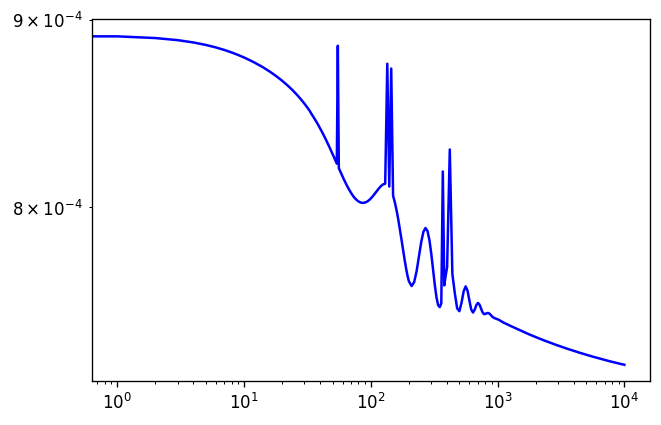

In [39]:
nc_cl = np.array (vp.dup_array ())

fig = plt.figure (dpi = 120)

lmax = 10000

ells = np.array(ells).astype(int)


#plt.plot (ells, cl_g1_histo_bessel, 'g')
#plt.plot (ells, nc_cl[ells], 'b')
plt.plot (ells, np.abs (nc_cl[ells] / cl_g1_histo_bessel - 1.0), 'b')
plt.xscale ('log')
plt.yscale ('log')

In [11]:
g1_analytic_bessel, ells, cl_g1_analytic_bessel = ccl_correlation('g1','analytic','bessel')
g1_histo_bessel, _, _ = ccl_correlation('g1','histo','bessel')
g1_analytic_fftlog, _, _ = ccl_correlation('g1','analytic','fftlog')
g1_histo_fftlog, _, _ = ccl_correlation('g1','histo','fftlog')

g2_analytic_bessel, _, _ = ccl_correlation('g2','analytic','bessel')
g2_histo_bessel, _, _ = ccl_correlation('g2','histo','bessel')
g2_analytic_fftlog, _, _ = ccl_correlation('g2','analytic','fftlog')
g2_histo_fftlog, _, _ = ccl_correlation('g2','histo','fftlog')

import matplotlib.pyplot as plt

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  70                  [FIXED]
#   -     Omegac[01]:  0.25                [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  0                   [FIXED]
#   -     Omegab[06]:  0.05                [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

KeyboardInterrupt: 

Plotting the graphs comparing the methods and their results for each Cl

In [ ]:
fig = plt.figure (dpi = 120)

plt.plot (ells, cl_g1_analytic_bessel)
plt.xscale ('log')
plt.yscale ('log')

In [ ]:


theta=[0.01258925,0.01995262,0.03162278,0.05011872,0.07943282,0.1258925,0.1995262,0.3162278,0.5011872,0.7943282,1.258925,1.995262,3.162278,5.011872,7.943282]


figs, axs = plt.subplots(nrows=1, ncols=4, sharex=True,figsize=(12, 6))

axs[0].plot(theta,g1_analytic_bessel, label='g1_analytic_bessel',color='b')
axs[0].plot(theta,g1_analytic_fftlog,label='g1_analytic_fftlog',color='skyblue')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\theta$',fontsize=16)
axs[0].set_ylabel(r'$C_ls$',fontsize=16)
axs[0].legend()

axs[1].plot(theta,g1_histo_bessel, label='g1_histo_bessel',color='b')
axs[1].plot(theta,g1_histo_fftlog, label='g1_histo_fftlog',color='skyblue')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\theta$',fontsize=16)
axs[1].set_yticks([])
axs[1].legend()

axs[2].plot(theta,g2_analytic_bessel, label='g2_analytic_bessel',color='b')
axs[2].plot(theta,g2_analytic_fftlog, label='g2_analytic_fftlog',color='skyblue')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\theta$',fontsize=16)
axs[2].set_yticks([])
axs[2].legend()

axs[3].plot(theta,g2_histo_bessel, label='g2_histo_bessel',color='b')
axs[3].plot(theta,g2_histo_fftlog, label='g2_histo_fftlog',color='skyblue')
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel(r'$\theta$',fontsize=16)
axs[3].set_yticks([])
axs[3].legend()

##########################################################################
""" 

Attempt to graph the relative distance between the bessel method and the fftlog method
 below the graph of the representation of the Cls

axs[1,0].set_xlabel(r'$\theta$',fontsize=16)
axs[1,0].set_yscale('log')

axs[1,1].set_xlabel(r'$\theta$',fontsize=16)
axs[1,1].set_yscale('log')
axs[1,1].set_yticks([])
plt.show()


axs[1,2].set_xlabel(r'$\theta$',fontsize=16)
axs[1,2].set_yscale('log')
axs[1,2].set_yticks([])


axs[1,3].set_xlabel(r'$\theta$',fontsize=16)
axs[1,3].set_yscale('log')
axs[1,3].set_yticks([])
"""
plt.show()

Graphics of relative distances between Bessel method and Fftlog method.

In [ ]:
figs, axs = plt.subplots(nrows=1, ncols=4, sharex=True,figsize=(12, 6))

diff= { 'diff0':np.abs( g1_analytic_bessel-g1_analytic_fftlog ),
        'diff1':np.abs( g1_histo_bessel-g1_histo_fftlog ),
        'diff2':np.abs( g2_analytic_bessel-g2_analytic_fftlog ),
        'diff3':np.abs( g2_histo_bessel-g2_histo_fftlog )
}

axs[0].plot(theta,diff['diff0'], label='diff0',color='r')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\theta$',fontsize=16)
axs[0].set_ylabel('Diff: g1_analytic_bessel - g1_analytic_fftlog',fontsize=14,color='r')
axs[0].legend()

axs[1].plot(theta,diff['diff1'], label='diff1',color='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\theta$',fontsize=16)
axs[1].set_ylabel('Diff: g1_histo_bessel - g1_histo_fftlog',fontsize=14,color='r')
axs[1].legend()

axs[2].plot(theta,diff['diff2'], label='diff2',color='r')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\theta$',fontsize=16)
axs[2].set_ylabel('Diff: g2_analytic_bessel - g2_analytic_fftlog',fontsize=14,color='r')
axs[2].legend()

axs[3].plot(theta,diff['diff3'], label='diff3',color='r')
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel(r'$\theta$',fontsize=16)
axs[3].set_ylabel('Diff: g2_histo_bessel - g2_histo_fftlog',fontsize=14,color='r')
axs[3].legend()
plt.tight_layout()
plt.show()

Comparing Cls of different tracers calculated using the same method.

In [ ]:
theta=[0.01258925,0.01995262,0.03162278,0.05011872,0.07943282,0.1258925,0.1995262,0.3162278,0.5011872,0.7943282,1.258925,1.995262,3.162278,5.011872,7.943282]


figs, axs = plt.subplots(nrows=1, ncols=4, sharex=True,figsize=(12, 6))

axs[0].plot(theta,g1_analytic_bessel, label='g1_analytic_bessel',color='b')
axs[0].plot(theta,g2_analytic_bessel,label='g2_analytic_bessel',color='r')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\theta$',fontsize=16)
axs[0].set_ylabel(r'$C_ls$',fontsize=16)
axs[0].legend()

axs[1].plot(theta,g1_analytic_fftlog, label='g1_analytic_fftlog',color='b')
axs[1].plot(theta,g2_analytic_fftlog, label='g2_analytic_fftlog',color='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\theta$',fontsize=16)
axs[1].set_yticks([])
axs[1].legend()

axs[2].plot(theta,g1_histo_bessel, label='g1_histo_bessel',color='b')
axs[2].plot(theta,g2_histo_bessel,label='g2_histo_bessel',color='r')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\theta$',fontsize=16)
axs[2].set_yticks([])
axs[2].legend()

axs[3].plot(theta,g1_histo_fftlog, label='g1_histo_fftlog',color='b')
axs[3].plot(theta,g2_histo_fftlog, label='g2_histo_fftlog',color='r')
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel(r'$\theta$',fontsize=16)
axs[3].set_yticks([])
axs[3].legend()

plt.show()

Implementing NumCosmo's code

"""--------------------->Data for the construction of the test for NumCosmo


lmax = 10000
nls = (lmax - 400) // 20 + 141
ells = np.zeros(nls)
ells[:101] = np.arange(101)
ells[101:121] = ells[100] + (np.arange(20) + 1) * 5
ells[121:141] = ells[120] + (np.arange(20) + 1) * 10
ells[141:] = ells[140] + (np.arange(nls - 141) + 1) * 20

osmo = ccl.Cosmology(Omega_c=0.30, Omega_b=0.00, Omega_g=0, Omega_k=0,
                              h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                              w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                              mass_function='tinker',
                              matter_power_spectrum='linear')

    cosmo.cosmo.gsl_params.INTEGRATION_LIMBER_EPSREL = 2.5E-5
    cosmo.cosmo.gsl_params.INTEGRATION_EPSREL = 2.5E-5

if nztyp == 'analytic':
        # Analytic case
        zmean_1 = 1.0
        sigz_1 = 0.15
        zmean_2 = 1.5
        sigz_2 = 0.15
        z1 = [0.2514648,0.2543945,0.2573242,0.2602539,0.2631836,0.2661133,0.269043,0.2719727,0.2749023,0.277832,0.2807617,0.2836914,0.2866211,0.2895508,0.2924805,0.2954102,0.2983398,0.3012695,0.3041992,0.3071289,0.3100586,0.3129883,0.315918,0.3188477,0.3217773,0.324707,0.3276367,0.3305664,0.3334961,0.3364258,0.3393555,0.3422852,0.3452148,0.3481445,0.3510742,0.3540039,0.3569336,0.3598633,0.362793,0.3657227,0.3686523,0.371582,0.3745117,0.3774414,0.3803711,0.3833008,0.3862305,0.3891602,0.3920898,0.3950195,0.3979492,0.4008789,0.4038086,0.4067383,0.409668,0.4125977,0.4155273,0.418457,0.4213867,0.4243164,0.4272461,0.4301758,0.4331055,0.4360352,0.4389648,0.4418945,0.4448242,0.4477539,0.4506836,0.4536133,0.456543,0.4594727,0.4624023,0.465332,0.4682617,0.4711914,0.4741211,0.4770508,0.4799805,0.4829102,0.4858398,0.4887695,0.4916992,0.4946289,0.4975586,0.5004883,0.503418,0.5063477,0.5092773,0.512207,0.5151367,0.5180664,0.5209961,0.5239258,0.5268555,0.5297852,0.5327148,0.5356445,0.5385742,0.5415039,0.5444336,0.5473633,0.550293,0.5532227,0.5561523,0.559082,0.5620117,0.5649414,0.5678711,0.5708008,0.5737305,0.5766602,0.5795898,0.5825195,0.5854492,0.5883789,0.5913086,0.5942383,0.597168,0.6000977,0.6030273,0.605957,0.6088867,0.6118164,0.6147461,0.6176758,0.6206055,0.6235352,0.6264648,0.6293945,0.6323242,0.6352539,0.6381836,0.6411133,0.644043,0.6469727,0.6499023,0.652832,0.6557617,0.6586914,0.6616211,0.6645508,0.6674805,0.6704102,0.6733398,0.6762695,0.6791992,0.6821289,0.6850586,0.6879883,0.690918,0.6938477,0.6967773,0.699707,0.7026367,0.7055664,0.7084961,0.7114258,0.7143555,0.7172852,0.7202148,0.7231445,0.7260742,0.7290039,0.7319336,0.7348633,0.737793,0.7407227,0.7436523,0.746582,0.7495117,0.7524414,0.7553711,0.7583008,0.7612305,0.7641602,0.7670898,0.7700195,0.7729492,0.7758789,0.7788086,0.7817383,0.784668,0.7875977,0.7905273,0.793457,0.7963867,0.7993164,0.8022461,0.8051758,0.8081055,0.8110352,0.8139648,0.8168945,0.8198242,0.8227539,0.8256836,0.8286133,0.831543,0.8344727,0.8374023,0.840332,0.8432617,0.8461914,0.8491211,0.8520508,0.8549805,0.8579102,0.8608398,0.8637695,0.8666992,0.8696289,0.8725586,0.8754883,0.878418,0.8813477,0.8842773,0.887207,0.8901367,0.8930664,0.8959961,0.8989258,0.9018555,0.9047852,0.9077148,0.9106445,0.9135742,0.9165039,0.9194336,0.9223633,0.925293,0.9282227,0.9311523,0.934082,0.9370117,0.9399414,0.9428711,0.9458008,0.9487305,0.9516602,0.9545898,0.9575195,0.9604492,0.9633789,0.9663086,0.9692383,0.972168,0.9750977,0.9780273,0.980957,0.9838867,0.9868164,0.9897461,0.9926758,0.9956055,0.9985352,1.001465,1.004395,1.007324,1.010254,1.013184,1.016113,1.019043,1.021973,1.024902,1.027832,1.030762,1.033691,1.036621,1.039551,1.04248,1.04541,1.04834,1.05127,1.054199,1.057129,1.060059,1.062988,1.065918,1.068848,1.071777,1.074707,1.077637,1.080566,1.083496,1.086426,1.089355,1.092285,1.095215,1.098145,1.101074,1.104004,1.106934,1.109863,1.112793,1.115723,1.118652,1.121582,1.124512,1.127441,1.130371,1.133301,1.13623,1.13916,1.14209,1.14502,1.147949,1.150879,1.153809,1.156738,1.159668,1.162598,1.165527,1.168457,1.171387,1.174316,1.177246,1.180176,1.183105,1.186035,1.188965,1.191895,1.194824,1.197754,1.200684,1.203613,1.206543,1.209473,1.212402,1.215332,1.218262,1.221191,1.224121,1.227051,1.22998,1.23291,1.23584,1.23877,1.241699,1.244629,1.247559,1.250488,1.253418,1.256348,1.259277,1.262207,1.265137,1.268066,1.270996,1.273926,1.276855,1.279785,1.282715,1.285645,1.288574,1.291504,1.294434,1.297363,1.300293,1.303223,1.306152,1.309082,1.312012,1.314941,1.317871,1.320801,1.32373,1.32666,1.32959,1.33252,1.335449,1.338379,1.341309,1.344238,1.347168,1.350098,1.353027,1.355957,1.358887,1.361816,1.364746,1.367676,1.370605,1.373535,1.376465,1.379395,1.382324,1.385254,1.388184,1.391113,1.394043,1.396973,1.399902,1.402832,1.405762,1.408691,1.411621,1.414551,1.41748,1.42041,1.42334,1.42627,1.429199,1.432129,1.435059,1.437988,1.440918,1.443848,1.446777,1.449707,1.452637,1.455566,1.458496,1.461426,1.464355,1.467285,1.470215,1.473145,1.476074,1.479004,1.481934,1.484863,1.487793,1.490723,1.493652,1.496582,1.499512,1.502441,1.505371,1.508301,1.51123,1.51416,1.51709,1.52002,1.522949,1.525879,1.528809,1.531738,1.534668,1.537598,1.540527,1.543457,1.546387,1.549316,1.552246,1.555176,1.558105,1.561035,1.563965,1.566895,1.569824,1.572754,1.575684,1.578613,1.581543,1.584473,1.587402,1.590332,1.593262,1.596191,1.599121,1.602051,1.60498,1.60791,1.61084,1.61377,1.616699,1.619629,1.622559,1.625488,1.628418,1.631348,1.634277,1.637207,1.640137,1.643066,1.645996,1.648926,1.651855,1.654785,1.657715,1.660645,1.663574,1.666504,1.669434,1.672363,1.675293,1.678223,1.681152,1.684082,1.687012,1.689941,1.692871,1.695801,1.69873,1.70166,1.70459,1.70752,1.710449,1.713379,1.716309,1.719238,1.722168,1.725098,1.728027,1.730957,1.733887,1.736816,1.739746,1.742676,1.745605,1.748535]
        z2 = [0.7514648,0.7543945,0.7573242,0.7602539,0.7631836,0.7661133,0.769043,0.7719727,0.7749023,0.777832,0.7807617,0.7836914,0.7866211,0.7895508,0.7924805,0.7954102,0.7983398,0.8012695,0.8041992,0.8071289,0.8100586,0.8129883,0.815918,0.8188477,0.8217773,0.824707,0.8276367,0.8305664,0.8334961,0.8364258,0.8393555,0.8422852,0.8452148,0.8481445,0.8510742,0.8540039,0.8569336,0.8598633,0.862793,0.8657227,0.8686523,0.871582,0.8745117,0.8774414,0.8803711,0.8833008,0.8862305,0.8891602,0.8920898,0.8950195,0.8979492,0.9008789,0.9038086,0.9067383,0.909668,0.9125977,0.9155273,0.918457,0.9213867,0.9243164,0.9272461,0.9301758,0.9331055,0.9360352,0.9389648,0.9418945,0.9448242,0.9477539,0.9506836,0.9536133,0.956543,0.9594727,0.9624023,0.965332,0.9682617,0.9711914,0.9741211,0.9770508,0.9799805,0.9829102,0.9858398,0.9887695,0.9916992,0.9946289,0.9975586,1.000488,1.003418,1.006348,1.009277,1.012207,1.015137,1.018066,1.020996,1.023926,1.026855,1.029785,1.032715,1.035645,1.038574,1.041504,1.044434,1.047363,1.050293,1.053223,1.056152,1.059082,1.062012,1.064941,1.067871,1.070801,1.07373,1.07666,1.07959,1.08252,1.085449,1.088379,1.091309,1.094238,1.097168,1.100098,1.103027,1.105957,1.108887,1.111816,1.114746,1.117676,1.120605,1.123535,1.126465,1.129395,1.132324,1.135254,1.138184,1.141113,1.144043,1.146973,1.149902,1.152832,1.155762,1.158691,1.161621,1.164551,1.16748,1.17041,1.17334,1.17627,1.179199,1.182129,1.185059,1.187988,1.190918,1.193848,1.196777,1.199707,1.202637,1.205566,1.208496,1.211426,1.214355,1.217285,1.220215,1.223145,1.226074,1.229004,1.231934,1.234863,1.237793,1.240723,1.243652,1.246582,1.249512,1.252441,1.255371,1.258301,1.26123,1.26416,1.26709,1.27002,1.272949,1.275879,1.278809,1.281738,1.284668,1.287598,1.290527,1.293457,1.296387,1.299316,1.302246,1.305176,1.308105,1.311035,1.313965,1.316895,1.319824,1.322754,1.325684,1.328613,1.331543,1.334473,1.337402,1.340332,1.343262,1.346191,1.349121,1.352051,1.35498,1.35791,1.36084,1.36377,1.366699,1.369629,1.372559,1.375488,1.378418,1.381348,1.384277,1.387207,1.390137,1.393066,1.395996,1.398926,1.401855,1.404785,1.407715,1.410645,1.413574,1.416504,1.419434,1.422363,1.425293,1.428223,1.431152,1.434082,1.437012,1.439941,1.442871,1.445801,1.44873,1.45166,1.45459,1.45752,1.460449,1.463379,1.466309,1.469238,1.472168,1.475098,1.478027,1.480957,1.483887,1.486816,1.489746,1.492676,1.495605,1.498535,1.501465,1.504395,1.507324,1.510254,1.513184,1.516113,1.519043,1.521973,1.524902,1.527832,1.530762,1.533691,1.536621,1.539551,1.54248,1.54541,1.54834,1.55127,1.554199,1.557129,1.560059,1.562988,1.565918,1.568848,1.571777,1.574707,1.577637,1.580566,1.583496,1.586426,1.589355,1.592285,1.595215,1.598145,1.601074,1.604004,1.606934,1.609863,1.612793,1.615723,1.618652,1.621582,1.624512,1.627441,1.630371,1.633301,1.63623,1.63916,1.64209,1.64502,1.647949,1.650879,1.653809,1.656738,1.659668,1.662598,1.665527,1.668457,1.671387,1.674316,1.677246,1.680176,1.683105,1.686035,1.688965,1.691895,1.694824,1.697754,1.700684,1.703613,1.706543,1.709473,1.712402,1.715332,1.718262,1.721191,1.724121,1.727051,1.72998,1.73291,1.73584,1.73877,1.741699,1.744629,1.747559,1.750488,1.753418,1.756348,1.759277,1.762207,1.765137,1.768066,1.770996,1.773926,1.776855,1.779785,1.782715,1.785645,1.788574,1.791504,1.794434,1.797363,1.800293,1.803223,1.806152,1.809082,1.812012,1.814941,1.817871,1.820801,1.82373,1.82666,1.82959,1.83252,1.835449,1.838379,1.841309,1.844238,1.847168,1.850098,1.853027,1.855957,1.858887,1.861816,1.864746,1.867676,1.870605,1.873535,1.876465,1.879395,1.882324,1.885254,1.888184,1.891113,1.894043,1.896973,1.899902,1.902832,1.905762,1.908691,1.911621,1.914551,1.91748,1.92041,1.92334,1.92627,1.929199,1.932129,1.935059,1.937988,1.940918,1.943848,1.946777,1.949707,1.952637,1.955566,1.958496,1.961426,1.964355,1.967285,1.970215,1.973145,1.976074,1.979004,1.981934,1.984863,1.987793,1.990723,1.993652,1.996582,1.999512,2.002441,2.005371,2.008301,2.01123,2.01416,2.01709,2.02002,2.022949,2.025879,2.028809,2.031738,2.034668,2.037598,2.040527,2.043457,2.046387,2.049316,2.052246,2.055176,2.058105,2.061035,2.063965,2.066895,2.069824,2.072754,2.075684,2.078613,2.081543,2.084473,2.087402,2.090332,2.093262,2.096191,2.099121,2.102051,2.10498,2.10791,2.11084,2.11377,2.116699,2.119629,2.122559,2.125488,2.128418,2.131348,2.134277,2.137207,2.140137,2.143066,2.145996,2.148926,2.151855,2.154785,2.157715,2.160645,2.163574,2.166504,2.169434,2.172363,2.175293,2.178223,2.181152,2.184082,2.187012,2.189941,2.192871,2.195801,2.19873,2.20166,2.20459,2.20752,2.210449,2.213379,2.216309,2.219238,2.222168,2.225098,2.228027,2.230957,2.233887,2.236816,2.239746,2.242676,2.245605,2.248535]
        z1=np.array(z1)
        z2=np.array(z2)
        pz1 = np.exp(-0.5 * ((z1 - zmean_1) / sigz_1) ** 2)
        pz2 = np.exp(-0.5 * ((z2 - zmean_2) / sigz_2) ** 2)

elif nztyp == 'histo':
        # Histogram case
        z1 = [0.51125,0.51875,0.52625,0.5337500000000001,0.54125,0.5487500000000001,0.55625,0.5637500000000001,0.57125,0.57875,0.58625,0.59375,0.6012500000000001,0.60875,0.6162500000000001,0.62375,0.63125,0.63875,0.64625,0.65375,0.66125,0.6687500000000001,0.67625,0.6837500000000001,0.69125,0.69875,0.70625,0.71375,0.7212500000000001,0.72875,0.7362500000000001,0.74375,0.7512500000000001,0.75875,0.76625,0.77375,0.78125,0.7887500000000001,0.79625,0.8037500000000001,0.81125,0.81875,0.82625,0.83375,0.84125,0.84875,0.8562500000000001,0.86375,0.8712500000000001,0.87875,0.88625,0.89375,0.90125,0.9087500000000001,0.91625,0.9237500000000001,0.93125,0.9387500000000001,0.94625,0.95375,0.96125,0.96875,0.9762500000000001,0.98375,0.9912500000000001,0.99875,1.0062499999999999,1.01375,1.02125,1.0287499999999998,1.03625,1.04375,1.05125,1.0587499999999999,1.06625,1.07375,1.0812499999999998,1.0887499999999999,1.09625,1.10375,1.1112499999999998,1.11875,1.12625,1.1337499999999998,1.1412499999999999,1.14875,1.15625,1.1637499999999998,1.17125,1.17875,1.18625,1.1937499999999999,1.20125,1.20875,1.2162499999999998,1.22375,1.23125,1.23875,1.2462499999999999,1.25375,1.26125,1.2687499999999998,1.2762499999999999,1.28375,1.29125,1.2987499999999998,1.30625,1.31375,1.3212499999999998,1.3287499999999999,1.33625,1.34375,1.3512499999999998,1.35875,1.36625,1.37375,1.3812499999999999,1.38875,1.39625,1.4037499999999998,1.41125,1.41875,1.42625,1.4337499999999999,1.44125,1.44875,1.4562499999999998,1.4637499999999999,1.47125,1.47875,1.4862499999999998,1.49375,1.50125,1.5087499999999998,1.5162499999999999,1.52375,1.53125,1.5387499999999998,1.54625,1.55375,1.56125,1.5687499999999999,1.57625,1.58375,1.5912499999999998,1.59875,1.60625,1.61375,1.6212499999999999,1.62875,1.63625,1.6437499999999998,1.6512499999999999,1.65875,1.66625,1.6737499999999998,1.68125,1.68875,1.6962499999999998,1.7037499999999999,1.71125,1.71875,1.7262499999999998,1.73375,1.74125,1.74875,1.7562499999999999,1.76375,1.77125,1.7787499999999998,1.78625,1.79375,1.80125,1.8087499999999999,1.81625,1.82375,1.8312499999999998,1.8387499999999999,1.84625,1.85375,1.8612499999999998,1.86875,1.87625,1.8837499999999998,1.8912499999999999,1.89875,1.90625,1.9137499999999998,1.92125,1.92875,1.93625,1.9437499999999999,1.95125,1.95875,1.9662499999999998,1.97375,1.98125,1.98875,1.9962499999999999]
        pz1 = [0.03042845,0.03414402,0.03799253,0.04299767,0.05033486,0.06090954,0.07214195,0.08122409,0.09440498,0.1069006,0.1193231,0.1345755,0.1574345,0.1814089,0.2129027,0.2362395,0.2668045,0.3002025,0.3352957,0.3745351,0.4194854,0.4623063,0.5050753,0.5454309,0.5963121,0.6618579,0.7288298,0.8091178,0.898688,0.9962031,1.104119,1.216311,1.32999,1.435197,1.512844,1.58501,1.652862,1.703158,1.741018,1.772948,1.774767,1.763834,1.737957,1.726589,1.737972,1.753971,1.763453,1.802562,1.856402,1.900287,1.9703,2.067721,2.174633,2.281516,2.373034,2.444509,2.524466,2.565968,2.591811,2.636548,2.668677,2.667052,2.662519,2.650229,2.636122,2.642808,2.631578,2.617414,2.585296,2.516713,2.433994,2.371482,2.312537,2.243322,2.161209,2.053728,1.949206,1.849159,1.756659,1.680961,1.607236,1.512338,1.403549,1.296255,1.194675,1.099351,1.006349,0.9175507,0.8346777,0.7518989,0.6750844,0.6090778,0.5471522,0.4921195,0.4383578,0.3932878,0.3505944,0.3069157,0.2660076,0.2260665,0.1912351,0.1602497,0.1342543,0.1105429,0.09371526,0.07828563,0.06450086,0.05691218,0.05188841,0.04927132,0.04626028,0.04556604,0.04560567,0.04429971,0.04462289,0.04330885,0.04531251,0.04556658,0.04682577,0.04804921,0.05014561,0.05017483,0.04971365,0.0498952,0.05009804,0.05045293,0.05051581,0.05173462,0.05239803,0.05211333,0.05046592,0.04824938,0.04685445,0.04832953,0.04773316,0.04719018,0.04581053,0.04330763,0.04180981,0.0409335,0.03975677,0.03999396,0.04020634,0.04043189,0.03879762,0.03973875,0.03834657,0.03841882,0.03693463,0.03597824,0.03656528,0.03627733,0.0368738,0.03706237,0.03943152,0.03926759,0.04037174,0.04044818,0.04122869,0.04159501,0.0407858,0.04100093,0.03983945,0.03702105,0.035423,0.03340422,0.03194788,0.0302819,0.02866295,0.0283969,0.02863473,0.02794187,0.02742471,0.02713259,0.02723712,0.02731734,0.02779379,0.02876089,0.02951878,0.0293301,0.02866049,0.02870192,0.02811025,0.02743557,0.0259726,0.02577944,0.02464586,0.02338112,0.0217144,0.02120506,0.02094031,0.01955321,0.01917961,0.01865226,0.01782826,0.01645653,0.01553533,0.01498327,0.01385961]
        pz2 = [0.02052227,0.02128476,0.02239694,0.02465136,0.02586701,0.03179429,0.03392884,0.0367469,0.04154996,0.04243694,0.04518474,0.04727245,0.05213725,0.06062088,0.06824402,0.07278402,0.08242115,0.09059329,0.09545925,0.1037852,0.1127547,0.1194203,0.1214864,0.1178928,0.1201941,0.1196488,0.1201862,0.1167615,0.1193688,0.1208544,0.1229058,0.1242607,0.1239687,0.1270272,0.1243528,0.1200976,0.1130248,0.1113359,0.1040341,0.09660113,0.08767327,0.08330837,0.07821314,0.07217775,0.06684813,0.06545177,0.06539616,0.06688858,0.06832995,0.06796344,0.07096691,0.07170753,0.07706039,0.08479357,0.09471338,0.1036854,0.1107307,0.1190918,0.1282902,0.1383972,0.1526025,0.1626396,0.1764611,0.1898772,0.1983843,0.2129817,0.2242674,0.2358476,0.2481126,0.2667389,0.2783668,0.3034779,0.3362693,0.3685216,0.4165157,0.4673775,0.521112,0.5931014,0.6609077,0.7264559,0.7962301,0.8749996,0.9607969,1.056802,1.156963,1.256299,1.378734,1.510344,1.672523,1.851898,2.039046,2.210871,2.363395,2.487797,2.587954,2.669776,2.745778,2.766685,2.737778,2.669233,2.582152,2.480724,2.370255,2.269433,2.185606,2.102805,1.983777,1.888873,1.804964,1.731546,1.668124,1.623094,1.573137,1.527214,1.473416,1.422128,1.393125,1.351983,1.336813,1.346803,1.351484,1.340388,1.352429,1.367506,1.368783,1.370403,1.377519,1.385641,1.385694,1.353968,1.30617,1.262473,1.210346,1.161107,1.115958,1.081432,1.041388,1.007879,0.9826291,0.9673974,0.9631128,0.9654323,0.9540624,0.9355531,0.9179233,0.9064376,0.8738709,0.8401182,0.7926394,0.7452493,0.7113778,0.6816197,0.665836,0.6483249,0.6367261,0.6235866,0.6165185,0.6122504,0.6033517,0.5971109,0.5756226,0.54784,0.5118714,0.4759495,0.4347915,0.3872084,0.348376,0.3066147,0.2736164,0.2427426,0.22066,0.2012315,0.1880263,0.1787777,0.1752531,0.1687745,0.1658762,0.165598,0.1634433,0.1612935,0.1563185,0.1494878,0.1408261,0.1306753,0.1201645,0.1131836,0.1053328,0.09754543,0.08818486,0.07864627,0.07041585,0.06252,0.05618527,0.05119691,0.04662244,0.0394575,0.03291768,0.02839416,0.02382886]
        z2 = [0.51125,0.51875,0.52625,0.5337500000000001,0.54125,0.5487500000000001,0.55625,0.5637500000000001,0.57125,0.57875,0.58625,0.59375,0.6012500000000001,0.60875,0.6162500000000001,0.62375,0.63125,0.63875,0.64625,0.65375,0.66125,0.6687500000000001,0.67625,0.6837500000000001,0.69125,0.69875,0.70625,0.71375,0.7212500000000001,0.72875,0.7362500000000001,0.74375,0.7512500000000001,0.75875,0.76625,0.77375,0.78125,0.7887500000000001,0.79625,0.8037500000000001,0.81125,0.81875,0.82625,0.83375,0.84125,0.84875,0.8562500000000001,0.86375,0.8712500000000001,0.87875,0.88625,0.89375,0.90125,0.9087500000000001,0.91625,0.9237500000000001,0.93125,0.9387500000000001,0.94625,0.95375,0.96125,0.96875,0.9762500000000001,0.98375,0.9912500000000001,0.99875,1.0062499999999999,1.01375,1.02125,1.0287499999999998,1.03625,1.04375,1.05125,1.0587499999999999,1.06625,1.07375,1.0812499999999998,1.0887499999999999,1.09625,1.10375,1.1112499999999998,1.11875,1.12625,1.1337499999999998,1.1412499999999999,1.14875,1.15625,1.1637499999999998,1.17125,1.17875,1.18625,1.1937499999999999,1.20125,1.20875,1.2162499999999998,1.22375,1.23125,1.23875,1.2462499999999999,1.25375,1.26125,1.2687499999999998,1.2762499999999999,1.28375,1.29125,1.2987499999999998,1.30625,1.31375,1.3212499999999998,1.3287499999999999,1.33625,1.34375,1.3512499999999998,1.35875,1.36625,1.37375,1.3812499999999999,1.38875,1.39625,1.4037499999999998,1.41125,1.41875,1.42625,1.4337499999999999,1.44125,1.44875,1.4562499999999998,1.4637499999999999,1.47125,1.47875,1.4862499999999998,1.49375,1.50125,1.5087499999999998,1.5162499999999999,1.52375,1.53125,1.5387499999999998,1.54625,1.55375,1.56125,1.5687499999999999,1.57625,1.58375,1.5912499999999998,1.59875,1.60625,1.61375,1.6212499999999999,1.62875,1.63625,1.6437499999999998,1.6512499999999999,1.65875,1.66625,1.6737499999999998,1.68125,1.68875,1.6962499999999998,1.7037499999999999,1.71125,1.71875,1.7262499999999998,1.73375,1.74125,1.74875,1.7562499999999999,1.76375,1.77125,1.7787499999999998,1.78625,1.79375,1.80125,1.8087499999999999,1.81625,1.82375,1.8312499999999998,1.8387499999999999,1.84625,1.85375,1.8612499999999998,1.86875,1.87625,1.8837499999999998,1.8912499999999999,1.89875,1.90625,1.9137499999999998,1.92125,1.92875,1.93625,1.9437499999999999,1.95125,1.95875,1.9662499999999998,1.97375,1.98125,1.98875,1.9962499999999999]
        z1 = np.array(z1)
        z2 = np.array(z2)

theta=[0.01258925,0.01995262,0.03162278,0.05011872,0.07943282,0.1258925,0.1995262,0.3162278,0.5011872,0.7943282,1.258925,1.995262,3.162278,5.011872,7.943282]

cl = ccl.angular_cl(cosmo, trcs[trc], trcs[trc], ells)
ell = np.arange(lmax)
cli = interp1d(ells, cl, kind='cubic')(ell)

xi = ccl.correlation(cosmo, ell, cli, theta, type='NN', method=method)

""""